In [15]:
from flax import nnx 

import jax
import jax.numpy as jnp
from jax import random
from typing import Optional
import matplotlib.pyplot as plt

import torch
import cv2 
import numpy as np

In [7]:
from superpoint_jax import SuperPoint as SP_jax
from superpoint_torch import SuperPoint as SP_torch

In [8]:
!wget https://github.com/rpautrat/SuperPoint/raw/refs/heads/master/weights/superpoint_v6_from_tf.pth

--2025-01-08 11:33:14--  https://github.com/rpautrat/SuperPoint/raw/refs/heads/master/weights/superpoint_v6_from_tf.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rpautrat/SuperPoint/refs/heads/master/weights/superpoint_v6_from_tf.pth [following]
--2025-01-08 11:33:15--  https://raw.githubusercontent.com/rpautrat/SuperPoint/refs/heads/master/weights/superpoint_v6_from_tf.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5251225 (5.0M) [application/octet-stream]
Saving to: ‘superpoint_v6_from_tf.pth’

superpoint_v6_from_ 100%[===================>]   5.01M  1.08MB/s    in 6.8s    

2025-01-

In [11]:
def plot_imgs(imgs, titles=None, cmap='brg', ylabel='', normalize=False, ax=None, dpi=100):
    """
        https://github.com/rpautrat/SuperPoint/blob/master/notebooks/utils.py
    """
    n = len(imgs)
    if not isinstance(cmap, list):
        cmap = [cmap]*n
    if ax is None:
        _, ax = plt.subplots(1, n, figsize=(6*n, 6), dpi=dpi)
        if n == 1:
            ax = [ax]
    else:
        if not isinstance(ax, list):
            ax = [ax]
        assert len(ax) == len(imgs)
    for i in range(n):
        if imgs[i].shape[-1] == 3:
            imgs[i] = imgs[i][..., ::-1]  # BGR to RGB
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmap[i]),
                     vmin=None if normalize else 0,
                     vmax=None if normalize else 1)
        if titles:
            ax[i].set_title(titles[i])
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
    ax[0].set_ylabel(ylabel)
    plt.tight_layout()

100.0%


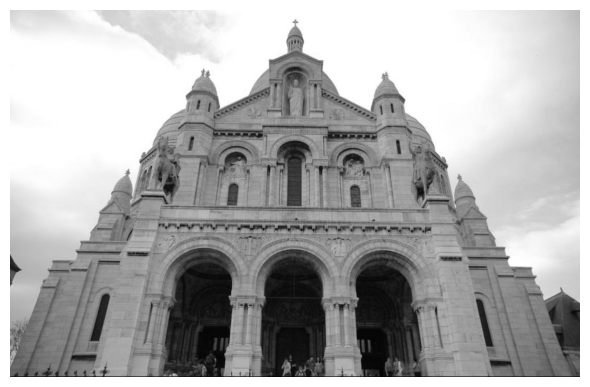

In [16]:
image_url = 'https://raw.githubusercontent.com/cvg/Hierarchical-Localization/master/datasets/sacre_coeur/mapping/03903474_1471484089.jpg'
image_path = 'image_sacre_coeur.jpg'
torch.hub.download_url_to_file(image_url, image_path)

image = cv2.imread(image_path).mean(-1) / 255
image = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])
plot_imgs([image], cmap='gray')

In [18]:
from pprint import pprint
from pathlib import Path
import numpy as np
import cv2
import yaml
import torch
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1 as tf
assert tf.__version__ < '2', 'Requires TF 1.x'

detection_thresh = 0.005
nms_radius = 5

2025-01-08 11:45:51.202990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736358351.230884  195711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736358351.237592  195711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [20]:
detection_thresh = 0.005
nms_radius = 5
path_pretrained_model = 'superpoint_v6_from_tf.pth'

sp_torch = SP_torch(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
state_dict = torch.load(path_pretrained_model)
sp_torch.load_state_dict(state_dict)

/tmp/ipykernel_195711/3606411061.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_pretrained_model)


<All keys matched successfully>

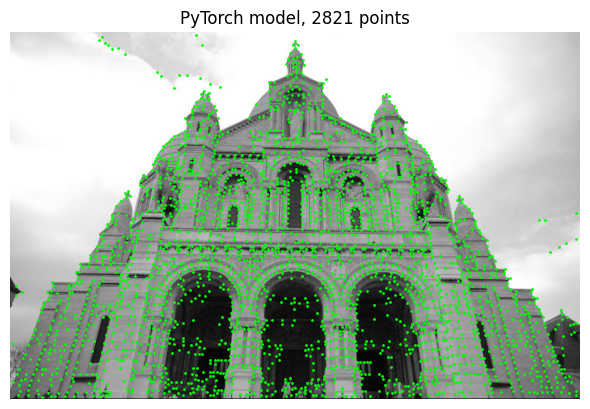

In [21]:
with torch.no_grad():
    pred_th = sp_torch({'image': torch.from_numpy(image[None,None]).float()})
points_th = pred_th['keypoints'][0]
plot_imgs([image], cmap='gray', titles=[f'PyTorch model, {len(points_th)} points'])
plt.scatter(*points_th.T, lw=0, s=4, c='lime');